In [1]:
import torch
import numpy as np
import gpytorch 
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import seaborn as sns 
sns.set_style("whitegrid")

# Sample identification
from torch.distributions import constraints, transform_to
import torch.autograd as autograd
import torch.optim as optim

## Bayesian Optimization

### Step 1: Set up the Gaussian Model

In [2]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        # Constant Mean 
        self.mean_module = gpytorch.means.ConstantMean()
        # RBF Kenel Scaled 
        self.covr_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        # Computes a forward pass and returns a multivariate normal distribution 
        mean_x = self.mean_module(x)
        covr_x = self.covr_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covr_x)

So mathematically speaking, when the above model is invoked it computes the mean $\mu(x)$ and covariance matrix $k_{xx}$ and returns the multivariate gaussian distribution with the mean and covariance, i.e. $P(f|X,Y)$

### Step 2: Set up the likelihood

In [3]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

This is the inference step that computes $P(y^*|x^*,X,Y)$

### Verify the GP

Before we jump into the bayesian optimization, let us verify the GP performance with the RBF kernel.

In [4]:
# Synth Data 
X = torch.linspace(0, 2.0, 100) * np.pi
Y = torch.sin(X)
# Add some noise with a variance of 0.4
Y += torch.randn(Y.size()) * 0.4

Text(0.5, 1.0, 'Sampled Data from a Noisy Sine Wave')

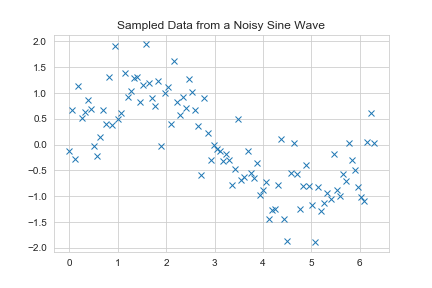

In [5]:
plt.plot(X.numpy(), Y.numpy(), 'x')
plt.title("Sampled Data from a Noisy Sine Wave")

#### Initalize the model 

In [6]:
gptest_model = GPModel(X, Y, likelihood)

#### Hyperparamter training

Before we start prediction on the new data based on the these samples, we need to tune out predictor, in this case our kenel function, to better the data better. This can be done in a multitude of ways, but with the Gpytorch we can leverage the autograd to solve the marginal likelihood to tune the hyperparameters. 

This is ideal because when we stackup complex kernels, working out the math can be tedious and coding up can be annoying. Pytorch can be used to do it for you. 

In [7]:
# Find optimal model hyperparameters
gptest_model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise()
)

In [8]:
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': gptest_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

In [9]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gptest_model)

In [10]:
training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gptest_model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 0.988
Iter 2/50 - Loss: 0.977
Iter 3/50 - Loss: 0.950
Iter 4/50 - Loss: 0.917
Iter 5/50 - Loss: 0.887
Iter 6/50 - Loss: 0.865
Iter 7/50 - Loss: 0.849
Iter 8/50 - Loss: 0.824
Iter 9/50 - Loss: 0.808
Iter 10/50 - Loss: 0.792
Iter 11/50 - Loss: 0.780
Iter 12/50 - Loss: 0.772
Iter 13/50 - Loss: 0.762
Iter 14/50 - Loss: 0.755
Iter 15/50 - Loss: 0.753
Iter 16/50 - Loss: 0.751
Iter 17/50 - Loss: 0.753
Iter 18/50 - Loss: 0.756
Iter 19/50 - Loss: 0.758
Iter 20/50 - Loss: 0.759
Iter 21/50 - Loss: 0.763
Iter 22/50 - Loss: 0.763
Iter 23/50 - Loss: 0.762
Iter 24/50 - Loss: 0.762
Iter 25/50 - Loss: 0.762
Iter 26/50 - Loss: 0.764
Iter 27/50 - Loss: 0.757
Iter 28/50 - Loss: 0.755
Iter 29/50 - Loss: 0.751
Iter 30/50 - Loss: 0.754
Iter 31/50 - Loss: 0.750
Iter 32/50 - Loss: 0.753
Iter 33/50 - Loss: 0.748
Iter 34/50 - Loss: 0.749
Iter 35/50 - Loss: 0.750
Iter 36/50 - Loss: 0.750
Iter 37/50 - Loss: 0.753
Iter 38/50 - Loss: 0.749
Iter 39/50 - Loss: 0.750
Iter 40/50 - Loss: 0.750
Iter 41/5

In [11]:
# Get into evaluation (predictive posterior) mode
gptest_model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
test_x = torch.linspace(0, 2, 100) * np.pi

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(gptest_model(test_x))

/usr/local/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:177: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


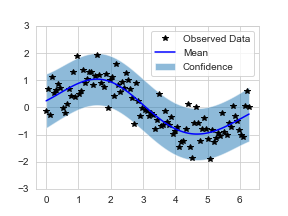

In [12]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X.numpy(), Y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

GP's performance looks good and the model seems to be working, let us head back to the bayesian optimization.

## Step 3: Create the acquision function:
In this example we would be using expected improvement.

In [49]:
def EI(x, observed_x, observed_y, model, likelihood, xi=0.1):
    """
    Computes the expected inprovement based on the GP
    """
    # Compute the mean of sampled points 
    observed_sam = likelihood(model(observed_x))
    mean_sam = observed_sam.mean
    # Compute the mean and covariance of new data
    observed_new = likelihood(model(x))
    mean_new = observed_new.mean
    vari_new = observed_new.variance
    # Standard Normal Distribution 
    nrml = torch.distributions.normal.Normal(0.0, 1.0)
    # Identify the max from the sampled data
    max_mean = mean_sam.max()
    # Compute Z 
    Z = (mean_new - max_mean - xi)/vari_new
    # Estimate the ei
    ei = (mean_new - max_mean - xi)*nrml.cdf(Z) + vari_new*torch.exp(nrml.log_prob(Z))
    if bool((vari_new > 0.0).numpy()):
        return ei 
    else:
        return ei * 0.0
    
def candidate_id(x_init,
                observed_x,
                observed_y,
                model,
                likelihood,
                lower_bound=0, upper_bound=1):
    """
    Identify the next point to sample based on the acquision function 
    and some pytorch magical beans 
    """
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = -EI(x, observed_x, observed_y, model, likelihood)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach(), EI(x, observed_x, observed_y, model, likelihood).detach()

## Bayesian Optimization Implementation 

In [54]:
# Create the function f
def f(X, noise=0.10):
    return -torch.sin(np.pi*X) - X**2 + 0.7*X + noise * torch.randn(*X.shape)
# Plot the function for visual clarity
X = torch.linspace(0, 1.0, 100)

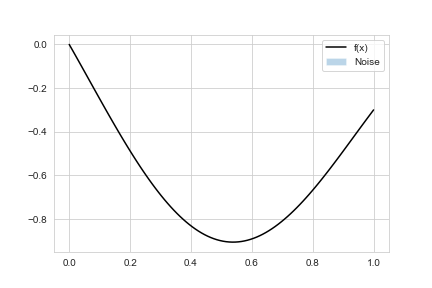

In [56]:
# plot the actial vave 
plt.plot(X.numpy(), f(X, noise=0.0).numpy(),'k')
# Plot the noise bounds 
plt.fill_between(X.numpy(), f(X, noise=0.0).numpy() - 2.0*0.0, f(X, noise=0.0).numpy() + 2.0*0.0, alpha=0.3)
plt.legend(["f(x)", "Noise"])

In [67]:
X_sampled = torch.tensor([0.20]) # Some inital starting point 
Y_sampled = f(X_sampled)

# Set up the optimization thingy 
gp_likihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model    = GPModel(X_sampled, Y_sampled, gp_likihood)

# Set up the number of iter 
num_ties = 30

# Datalog
datalog = {}
datalog["x_next"] = []
datalog["acqui"] = []
datalog["acqui_com"] = []

# Bayopt loop 
for i in range(0, num_ties):
    # Train the model based on the X_sampled and Y_sampled 
    
    # Find optimal model hyperparameters
    gp_model.train()
    gp_likihood.train()
    
    ## Optimizer 
    optimizer = torch.optim.Adam([{'params': gp_model.parameters()},], lr=0.1)
    
    ## "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp_likihood, gp_model)
    
    ## Tune the hyperparms 
    training_iter = 5
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = gptest_model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, Y)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
        
    # Get into evaluation (predictive posterior) mode
    gp_model.eval()
    gp_likihood.eval()
    
    temp_x = []
    temp_a = []
    
    for i in range(0, 5):
        # Get the candidate for eval 
        x0 = torch.FloatTensor(1).uniform_(0.0, 1.0)
        x_new, acq = candidate_id(x0,
                                  X_sampled,
                                  Y_sampled,
                                  gp_model,
                                  gp_likihood,
                                  lower_bound=0.0, upper_bound=1.0)
        temp_x.append(x_new)
        temp_a.append(acq)
    
    argmin = torch.max(torch.cat(temp_a), dim=0)[1].item()
    x_new = temp_x[argmin]
    acq = temp_a[argmin]
    datalog["x_next"].append(x_new.numpy())
    datalog["acqui"].append(acq.numpy())

    temp_c = []
    ta = torch.linspace(0.0, 1.0, 10)
    for i in ta:
        temp_c.append(EI(i.reshape(1,), X_sampled, Y_sampled, gp_model, gp_likihood))
    datalog["acqui_com"].append(temp_c)

    # Append to the sampled point 
    X_sampled = torch.cat((X_sampled, x_new), dim=0)
    Y_sampled = torch.cat((Y_sampled, f(x_new, noise=0.0)), dim=0)
    
    # reinitalize the model and liklihood 
    gp_likihood = gpytorch.likelihoods.GaussianLikelihood()
    gp_model    = GPModel(X_sampled, Y_sampled, gp_likihood)

In [68]:
# Get into evaluation (predictive posterior) mode
gp_model.eval()
gp_likihood.eval()

# Test points are regularly spaced along [0,1]
test_gp_x = torch.linspace(0, 1, 100)

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp_likihood(gp_model(test_gp_x))

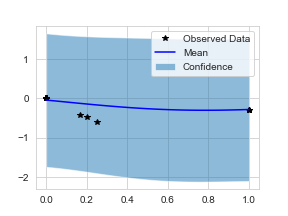

In [69]:
with torch.no_grad():
    # Initialize plot
    fi, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_sampled.numpy(), Y_sampled.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_gp_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_gp_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

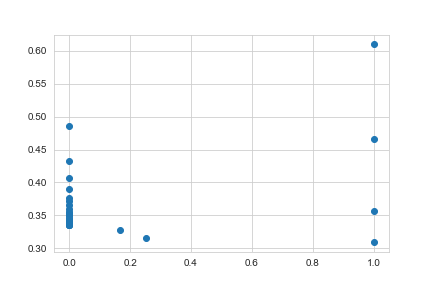

In [70]:
plt.plot(datalog["x_next"], datalog["acqui"], 'o')

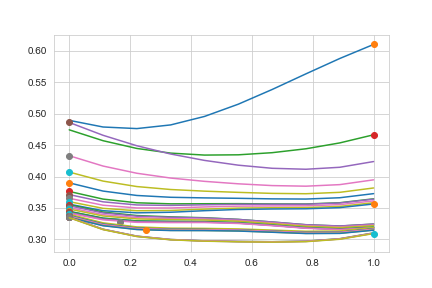

In [71]:
for i in range(0,30):
    plt.plot(torch.linspace(0.0, 1.0, 10).numpy(), datalog["acqui_com"][i])
    plt.plot(datalog["x_next"][i], datalog["acqui"][i], 'o')

In [39]:
datalog["x_next"]

[array([0.62889314], dtype=float32),
 array([0.7921812], dtype=float32),
 array([0.80924517], dtype=float32),
 array([0.5282169], dtype=float32),
 array([0.6667561], dtype=float32),
 array([0.72207636], dtype=float32),
 array([0.8647712], dtype=float32),
 array([0.79040486], dtype=float32),
 array([0.6888699], dtype=float32),
 array([0.99998045], dtype=float32),
 array([0.69691956], dtype=float32),
 array([0.69023705], dtype=float32),
 array([0.42285213], dtype=float32),
 array([0.6320981], dtype=float32),
 array([0.6344891], dtype=float32),
 array([0.76284516], dtype=float32),
 array([0.69833326], dtype=float32),
 array([0.70301306], dtype=float32),
 array([0.8106223], dtype=float32),
 array([0.787801], dtype=float32),
 array([0.58014214], dtype=float32),
 array([0.7120049], dtype=float32),
 array([0.68510073], dtype=float32),
 array([0.7857636], dtype=float32),
 array([0.5543575], dtype=float32),
 array([0.8273612], dtype=float32),
 array([0.7644636], dtype=float32),
 array([0.690023